# Using Amazon Sagemaker Clarify to support Decision Support in Hospital Triage

## Overview and Clinical Context:

Decision Support at admission time can be especially valuable for prioritization of resources in acn acute care linical setting such as a hosptial. These critical resources come in the form of doctors and nurses, as well as specialized beds, such as ones in the intensive care units. These place limits on the overall capacity of the hospital to treat patients.

Hosptials can more effectively use these resources by predicting the following:
diagnoses at discharge, procedures performed, in-hospital mortality and length-of-stay prediction

Novel approaches in NLP, such as Bidirectional Encoder Representations from Transformers (BERT) models, have allowed for inference on clinical data, and specifically notes, at an accuracy level not attainable a number of years ago. These advances make predicting key clinical indicators from notes data, and applying them in the real world, much more achieveable.

The following references articulate how these indicators have been developed and are being used:

1) "Clinical Outcome Prediction from Admission Notes using Self-Supervised Knowledge Integration" 
    - https://aclanthology.org/2021.eacl-main.75.pdf

2) "Prediction of emergency department patient disposition based on natural language processing of triage notes"
    - https://pubmed.ncbi.nlm.nih.gov/31445253/    

3) Application of Machine Learning in Intensive Care Unit (ICU) Settings Using MIMIC Dataset: Systematic Review
    - https://www.amjmed.com/article/S0002-9343(20)30688-4/abstract

## Overview of the Notebook:

The intent of this notebook is to provide a practical guide for data scientists, and machine learning engineers to collaborate with clinicians, and to support real implementations of clinical indicator predictions. As such, explainability of the algorithms is required.

Advances in NLP algorithms, as in the studies above, have made predicting clinical indicators more accurate, yet in order to effectively use machine learning models in a production setting, clinicians also need more insight into how these models work. They need to know that these algorithms make clinical sense before going to production. Clinicians and data scientists, need a way to evaluate realiablility, and explainability of models over time, as more data continues to be evaluated, and machine learning models are retrained.

This notebook will take one of these clinical triage indicators, in-hospital mortality, and show how AWS services and infrastructure, along with pre-trained HuggingFace BERT models, can be used to train a binary classifier on text data, estimate a threshold value for triage, and then use Amazon Sagemaker Clarify to explain what admission note text is supporting the recommendations the algorithm is making.

In this notebook we use the HuggingFace BERT Model - BIO_Discharge_Summary_BERT (https://huggingface.co/emilyalsentzer/Bio_Discharge_Summary_BERT). This is the pre-trained BERT model we will use in this notebook in order to demonstrate how NLP can be used to create a performant binary classifier for use in a clinical setting.

The notebook will also leverage a common, publicly available dataset directly; the MIMIC-III dataset (https://physionet.org/content/mimiciii-demo/1.4/). It will require a registration process, since the data is based on real-world acute care clinical data, but is a worthwhile for an organization, as this can be reused again for many different purposes.


## Pre-Requisites and Data

#### Getting Access to the MIMIC-III Dataset
- For our purposes of demonstrating the use of AWS services in this end to end process, we need to train the models on data which properly simulates real admission notes, and participates in triage decision support. For this reason, we chose to use the 'BIO Dishcarge Summary BERT HuggingFace Model', and then train a binary classifier on top of this model based on a the MIMIC-III datasets Notes table and hospital-expire-flag.

- The BIO Discharge Summary BERT model is trained on the MIMIC-III dataset, but for convenience sake, we will also be using this dataset in this notebook in order to build a binary classifier off of the notes field. In a real implementation, the dataset would be notes data would likely be from a hospitals Electronic Medical Records (EMR) system.

- In order to get access to the MIMIC-III dataset, please follow instructions here: https://physionet.org/content/mimiciii-demo/1.4/

#### Pre-Processing of the MIMIC-III dataset
- Our model is trained on data from a single feature from the MIMIC-III datasets 'noteevents' table and specifically the text field. This field however contains records that are created at the time of admission, as well as notes created throughout the patients stay, and thus require pre-processing.
- In order to pre-process the notes data - we leveraged the following Github project: https://github.com/bvanaken/clinical-outcome-prediction. 
- Within this project, use the step: "Create Admission Notes for Outcome Prediction from MIMIC-III" (this is included in our github implementation with references.) The MIMIC-III data is processed with these scripts, in order to summarize data that has been created during admission, and excludes all other data that would be entered, and know, after admission time. This is done in order to properly simulate data known at intake which is a key part of createing a valuable model for use at time of admission.
- Once the git repo above is downloaded,(or the one included in this project can be used as well), the steps within the section below "Data preparation" can be properly executed

After proper installation of the clinical outcome prediction Github project, or if you chooose to use the version downloaded and included in this Github project, your folder structure within SageMaker Jupyter Lab or SageMaker studio should look like the following.

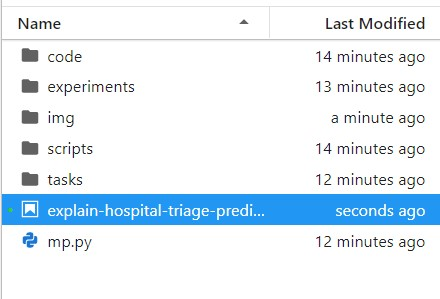

In [3]:
from IPython.display import Image
Image("img/file-structure.jpg")

## Sagemaker Kernel, and Installation of Required Packages and Package versions

Within Sagemaker, ensure that you use the "Python 3 (Data Science)" Kernel for this Notebook

Then run the following pip install statements below, to install the proper packages, and versions required to run the rest of the notebook


In [ ]:
# Install base aws packages
!pip install s3fs==0.5.0
!pip --quiet install boto3

In [ ]:
# Install transfomers package and upgrade
!pip --quiet install transformers
!pip --quiet install "transformers==4.6.1" --upgrade

In [8]:
# Import common libraries
import pandas as pd
# the mp library is the one that is used pre-process the mimic-iii dataset
import mp

# Import transformers related libraties
from transformers import AutoTokenizer, AutoModel
from transformers import Trainer
from transformers import AutoModelForSequenceClassification
from transformers import TrainingArguments

In [ ]:
# Install and import datasets
!pip --quiet install "datasets[s3]==1.6.2" --upgrade
from datasets import Dataset

In [ ]:
# Validate usage in notebook
!pip --quiet install captum

In [22]:
# Import libraries for data loading and pre-processing
import os
import numpy as np
import json
import botocore
import sagemaker
import tarfile
import s3fs
import boto3

from sagemaker.huggingface import HuggingFace
from sagemaker.pytorch import PyTorchModel
from sagemaker import get_execution_role, clarify
from captum.attr import visualization
from sklearn.model_selection import train_test_split
from datasets import Dataset
from datasets.filesystems import S3FileSystem

# SageMaker session bucket is used to upload the dataset, model and model training logs
sess = sagemaker.Session()
sess = sagemaker.Session(default_bucket=sess.default_bucket())
region = sess.boto_region_name
bucket = sess.default_bucket()
prefix = "sagemaker/DEMO-sagemaker-clarify-text"

# Define the IAM role
role = sagemaker.get_execution_role()

# SageMaker Clarify model directory name
model_path = "model/"

In [11]:
pd.set_option(
    'display.max_colwidth', 1000
)

seed = 40

### Data preparation 

Use the pre-processing libary, mp, that you installed from the github project https://github.com/bvanaken/clinical-outcome-prediction.

The python file, mp.py has been pre-downloaded and included in the root directory for use in this notebook. And if the clinical-outcome-prediction project is refreshed, please ensure mp.py is in the root directory once aga.

This library will operate on the csv files that have come through getting access to the MIMIC-III dataset.

Ensure that you create a data/raw directory, and then add the following MIMIC0III files: admissions.csv, diagnoses.csv, noteevents.csv, and procedures_icd.csv.

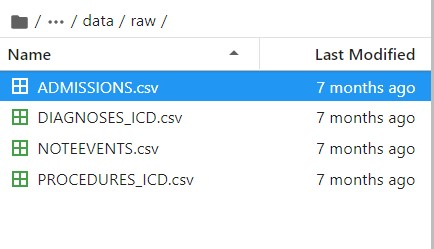

In [14]:
Image("img/data-raw-file.jpg")

In [17]:
mp.mp_in_hospital_mimic(mimic_dir="./data/raw", save_dir="./data/processed", seed=seed, admission_only=True)

In [18]:
train_data = pd.read_csv("./data/processed/MP_IN_adm_train.csv")
val_data = pd.read_csv("./data/processed/MP_IN_adm_val.csv")
test_data = pd.read_csv("./data/processed/MP_IN_adm_test.csv")

In [19]:
(train_data.shape,val_data.shape, test_data.shape)

((33954, 3), (4908, 3), (9822, 3))

#### Write out this data to S3 to be used by SageMaker

In [20]:
S3_BUCKET_NAME = "clarify-nlp-demo"
S3_OBJECT_NAME = "mortality-prediction-sagemaker/data"

Create an s3 bucket with the name S3_BUCKET_NAME above.
Then continue on with the next cell

In [23]:
s3 = boto3.resource('s3')
s3.meta.client.upload_file("./data/processed/MP_IN_adm_train.csv", S3_BUCKET_NAME, S3_OBJECT_NAME + 'train/train.csv')
s3.meta.client.upload_file("./data/processed/MP_IN_adm_val.csv", S3_BUCKET_NAME, S3_OBJECT_NAME + 'validation/validation.csv')
s3.meta.client.upload_file("./data/processed/MP_IN_adm_test.csv", S3_BUCKET_NAME, S3_OBJECT_NAME + 'test/test.csv')

training_input_path = "s3://" + S3_BUCKET_NAME + "/" + S3_OBJECT_NAME + "/train"
validation_input_path = "s3://" + S3_BUCKET_NAME + "/" + S3_OBJECT_NAME + "/validation"
test_input_path = "s3://" + S3_BUCKET_NAME + "/" + S3_OBJECT_NAME + "/test"

### Examine some data 

In [ ]:
train_data.head(5)

Check that train, validation and test data have similar distribution of classes

In [25]:
# to show inline
%matplotlib inline

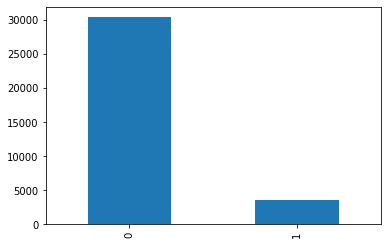

In [26]:
train_data['hospital_expire_flag'].value_counts().plot(kind='bar')

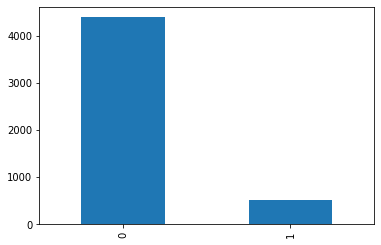

In [27]:
val_data['hospital_expire_flag'].value_counts().plot(kind='bar')

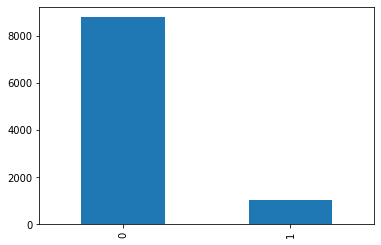

In [28]:
test_data['hospital_expire_flag'].value_counts().plot(kind='bar')

### Data Preparation for HuggingFace Model

The differences between class distribution in the datasets is small, but since we do see some differences, and expect that in the real world you could see differences, we will further prepare the data in a more standardized fashion, to ensure we have an equal representation of our hospital_expire_flag across the data sets. This is good practice for any dataset as well, and good to include in this notebook.

The most common approach for model evaluation is using the train/validation/test split. Although this approach can be very effective in general, it can result in misleading results and potentially fail when used on classification problems with a severe class imbalance. Instead, the technique must be modified to stratify the sampling by the class label as below. Stratification ensures that all classes are well represented across the train, validation and test datasets.

In [29]:
target = "hospital_expire_flag"
cols = "text"

# Define the data broken up in train,test,validation from the pre-processing steps.

# X_train and y_train
X_train = train_data[cols]
y_train = train_data[target]

# X_val and y_val
X_val = val_data[cols]
y_val = val_data[target]

# X_test and y_test
X_test = test_data[cols]
y_test = test_data[target]

X_frames = [X_train,X_val,X_test]
y_frames = [y_train,y_val,y_test]

# Combine the data again to make up our own train, test, validation sets
X = pd.concat(X_frames)
y = pd.concat(y_frames)

# Data split: 10%(val) of the 90% (train and test) of the dataset ~ 10%; resulting in 80:10:10split
test_dataset_size = 0.10
val_dataset_size = 0.10
RANDOM_STATE = 35

# Stratified train-val-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=test_dataset_size, stratify=y, random_state=RANDOM_STATE
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=val_dataset_size, stratify=y_train, random_state=RANDOM_STATE
)

print(
    "Dataset: train ",
    X_train.shape,
    y_train.shape,
    y_train.value_counts(dropna=False, normalize=True).to_dict(),
)
print(
    "Dataset: validation ",
    X_val.shape,
    y_val.shape,
    y_val.value_counts(dropna=False, normalize=True).to_dict(),
)
print(
    "Dataset: test ",
    X_test.shape,
    y_test.shape,
    y_test.value_counts(dropna=False, normalize=True).to_dict(),
)

# Combine the independent columns with the label
df_train = pd.concat([X_train, y_train], axis=1).reset_index(drop=True)
df_test = pd.concat([X_test, y_test], axis=1).reset_index(drop=True)
df_val = pd.concat([X_val, y_val], axis=1).reset_index(drop=True)

# Sample a subset to speed up training
df_train = df_train.sample(n=30000)
df_test_clarify = df_test.sample(n=3000)
df_val = df_val.sample(n=3000)

Dataset: train  (39433,) (39433,) {0: 0.895721857327619, 1: 0.104278142672381}
Dataset: validation  (4382,) (4382,) {0: 0.8957097215883159, 1: 0.10429027841168416}
Dataset: test  (4869,) (4869,) {0: 0.895666461285685, 1: 0.10433353871431505}


In [30]:
train_dataset = Dataset.from_pandas(df_train)
test_dataset = Dataset.from_pandas(df_val)

#### Upload prepared dataset to the S3
Here, we upload the prepared datasets to S3 buckets so that we can train the model with the Hugging Face Estimator.

In [31]:
# S3 key prefix for the datasets
s3_prefix = "explainability/datasets/mortality-prediction-blog"
s3 = S3FileSystem()

# save train_dataset to s3
training_input_path = f"s3://{sess.default_bucket()}/{s3_prefix}/train"
train_dataset.save_to_disk(training_input_path, fs=s3)

# save test_dataset to s3
test_input_path = f"s3://{sess.default_bucket()}/{s3_prefix}/test"
test_dataset.save_to_disk(test_input_path, fs=s3)

### Training on the Huggingface model

The CORe (Clinical Outcome Representations) model that is introduced in the paper "Clinical Outcome Prediction from Admission Notes using Self-Supervised Knowledge Integration" - https://aclanthology.org/2021.eacl-main.75.pdf. It is based on BioBERT and further pre-trained on clinical notes, disease descriptions and medical articles with a specialised Clinical Outcome Pre-Training objective.

The specific hugginface model used in this notebook is the emilyalsentzer/Bio_Discharge_Summary_BERT model and can be found here:
https://huggingface.co/emilyalsentzer/Bio_Discharge_Summary_BERT
It is also trained based on BioBERT, and MIMIC-III discharge notes.

### Train the Binary Classifier Model Using SageMaker

In [ ]:
# Hyperparameters passed into the training job

hyperparameters = {"epochs": 3, "model_name": "emilyalsentzer/Bio_Discharge_Summary_BERT"}

huggingface_estimator = HuggingFace(
    entry_point="train.py",
    source_dir="scripts",
    instance_type="ml.g5.4xlarge",
    instance_count=1,
    transformers_version="4.6.1",
    pytorch_version="1.7.1",
    py_version="py36",
    role=role,
    hyperparameters=hyperparameters,
)

# starting the train job with our uploaded datasets as input
huggingface_estimator.fit({"train": training_input_path, "test": test_input_path})

### Deploy and Predict

In [ ]:
! aws s3 cp {huggingface_estimator.model_data} model.tar.gz
! mkdir -p {model_path}
! tar -xvf model.tar.gz -C  {model_path}/

In [35]:
with tarfile.open("hf_model.tar.gz", mode="w:gz") as archive:
    archive.add(model_path, recursive=True)
    archive.add("code/")
prefix = s3_prefix.split("/")[-1]
zipped_model_path = sess.upload_data(path="hf_model.tar.gz", key_prefix=prefix + "/hf-model-sm")

In [36]:
zipped_model_path

's3://sagemaker-us-east-1-721929407510/mortality-prediction-blog/hf-model-sm/hf_model.tar.gz'

In [37]:
endpoint_name = "triage-prediction-endpoint-v1"

In [38]:
from sagemaker.huggingface.model import HuggingFaceModel

huggingface_model = HuggingFaceModel(
    model_data=zipped_model_path,  # path to your trained SageMaker model
    role=get_execution_role(),                            # IAM role with permissions to create an endpoint
    transformers_version="4.6",                           # Transformers version used
    pytorch_version="1.7",                                # PyTorch version used
    py_version='py36',                                    # Python version used
)

In [39]:
predictor = huggingface_model.deploy(
    initial_instance_count=1, instance_type="ml.m5.4xlarge", endpoint_name=endpoint_name
)

-----------!

In [40]:
# After deployment of the huggingface_model, the .name property will be available
model_name = huggingface_model.name

In [41]:
test_sentence1 = df_test['text']

predictor = sagemaker.predictor.Predictor(endpoint_name, sess)
predictor.serializer = sagemaker.serializers.CSVSerializer()
predictor.deserializer = sagemaker.deserializers.CSVDeserializer()
predictor.predict([[test_sentence1]])

[['0.013273918']]

### Calculating the best Threshold for Classification - Unbalanced classes

In a practical setting, as in the case of predicting in-hospital mortality, the predicted class is dervied from a probablity of the positive, and compared to threshold other than 0.50. In the case where there are unbalanced classes, a simple method to calcualte a threshold, that achieves a balance between precision and recall, is by using the precision-recall curve.

This will be done by running a set of test data against the deployed model.

In [42]:
# Display the PR Curve and ROC Curve
from numpy import argmax
from numpy import sqrt
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve
from matplotlib import pyplot

In [43]:
# Generate Predicted Probabilities on test data
testX = df_train['text'].reset_index(drop=True)
testy = df_train['hospital_expire_flag'].reset_index(drop=True)

yhat = pd.DataFrame()

# Use predictor.predict to get probablities for positive outcomes only
for i in range (0,3000):
    yhat = yhat.append(predictor.predict([[testX[i]]]))

##### Using the Precision Recall Curve

This is commonly used to get the F1 Score, which indicates a balance between precision and recall.
In addition, it can be used to give you a practical threshold to use when getting individual
probabilities of a positive class back from an endpoint

The outcome of the suggested threshold is much less than optimal for a production setting, but has been created through only a single run of the training algorithm for demonstration purposes here. As more epochs are run, or other optimizations are made, results of this threshold will improve greatly

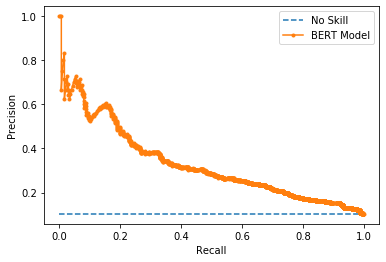

In [44]:
precision, recall, thresholds = precision_recall_curve(testy[:3000].astype(float), yhat.astype(float))
# plot the pr curve for the model
no_skill = len(testy[testy==1]) / len(testy)
pyplot.plot([0,1], [no_skill,no_skill], linestyle='--', label='No Skill')
pyplot.plot(recall, precision, marker='.', label='BERT Model')
# axis labels
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
pyplot.legend()
# show the plot
pyplot.show()

In [45]:
# Convert to f score

# F Score is a way to measure an algorithms ability to predict
# membership in a class
# see: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC8618756/ section 4.2 first paragraph

fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f' % (thresholds[ix], fscore[ix]))

Best Threshold=0.050156, F-Score=0.371


##### Using the Threshold
The best threshold value - which is defined here as thresholds[ix], will be used again further down in the notebook to demonstrate how it can be used to predict the binary class.

## Explain the predictions using Amazon Sagemaker Clarify

Now that we have trained our model, and determined a reasonable threshold which will be used to evaluate our Binary Classifier, let's use Amazon Sagemaker Clarify to explain the results of the NLP algorithm.

There are expanding business, clinical needs, and legislative regulations that require explanations of why a model made the decision it did. SageMaker Clarify uses SHAP to explain the contribution that each input feature makes to the final decision.

How does the Kernel SHAP algorithm work? Kernel SHAP algorithm is a local explanation method. That is, it explains each instance or row of the dataset at a time. To explain each instance, it perturbs the features values - that is, it changes the values of some features to a baseline (or non-informative) value, and then get predictions from the model for the perturbed samples. It does this for a number of times per instance (determined by the optional parameter num_samples in SHAPConfig), and computes the importance of each feature based on how the model prediction changed.

We are now extending this functionality to text data. In order to be able to explain text, we need the TextConfig. The TextConfig is an optional parameter of SHAPConfig, which you need to provide if you need explanations for the text features in your dataset. TextConfig in turn requires three parameters:

granularity (required): To explain text features, Clarify further breaks down text into smaller text units, and considers each such text unit as a feature. The parameter granularity informs the level to which Clarify will break down the text: token, sentence, or paragraph are the allowed values for granularity.
language (required): the language of the text features. This is required to tokenize the text to break them down to their granular form.
max_top_tokens (optional): the number of top token attributions that will be shown in the output (we need this because the size of vocabulary can be very big). This is an optional parameter, and defaults to 50.
Kernel SHAP algorithm requires a baseline (also known as background dataset). In case of tabular features, the baseline value/s for a feature is ideally a non-informative or least informative value for that feature. However, for text feature, the baseline values must be the value you want to replace the individual text feature (token, sentence or paragraph) with. For instance, in the example below, we have chosen the baseline values for review_text as <UNK>, and granularity is sentence. Every time a sentence has to replaced in the perturbed inputs, we will replace it with <UNK>.

If baseline is not provided, a baseline is calculated automatically by SageMaker Clarify using K-means or K-prototypes in the input dataset for tabular features. For text features, if baseline is not provided, the default replacement value will be the string <PAD>.

In [ ]:
# Select a random state that will get at least a few hosptial_expire_flag's that were 1
RANDOM_STATE = 80
# set a smaller number of samples for now
num_examples = 10

df_test["len"] = df_test["text"].apply(lambda ele: len(ele))

df_test_clarify = pd.DataFrame(
    df_test[df_test["len"] > 500].sample(n=num_examples, random_state=RANDOM_STATE),
    columns=["text","hospital_expire_flag"],
)

# Clarify expects a single text field, so just write out the single field to the csv
file_path = "clarify_data.csv"
df_test_clarify['text'].to_csv(file_path, header=True, index=False)

df_test_clarify

In [47]:
clarify_processor = clarify.SageMakerClarifyProcessor(
    role=role, instance_count=1, instance_type="ml.m5.xlarge", sagemaker_session=sess
)

model_config = clarify.ModelConfig(
    model_name=model_name,
    instance_type="ml.m5.4xlarge",
    instance_count=1,
    accept_type="text/csv",
    content_type="text/csv",
)

explainability_output_path = "s3://{}/{}/clarify-text-explainability".format(bucket, prefix)
explainability_data_config = clarify.DataConfig(
    s3_data_input_path=file_path,
    s3_output_path=explainability_output_path,
    headers=["text"],
    dataset_type="text/csv",
)

DataConfig will be deprecated on 15 Mar 2022.s3_data_distribution_type parameter will no longer be supported. Everything else will remain as is in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


In [48]:
shap_config = clarify.SHAPConfig(
    baseline=[["<UNK>"]],
    num_samples=1000,
    agg_method="mean_abs",
    save_local_shap_values=True,
    text_config=clarify.TextConfig(granularity="sentence", language="english"),
)

In [ ]:
# Running the clarify explainability job involves spinning up a processing job
# and a model endpoint which may take a few minutes.

# After this you will see a progress bar for the SHAP computation.
# The size of the dataset (num_examples) and the num_samples for shap will effect the running time.
clarify_processor.run_explainability(
    data_config=explainability_data_config,
    model_config=model_config,
    explainability_config=shap_config,
)

### Visualize Local Explanations
We use Captum to visualize the feature importances computed by Clarify. First, lets load the local explanations. Local text explanations can be found in the analysis results folder in a file named out.jsonl in the explanations_shap directory.

In [50]:
local_feature_attributions_file = "out.jsonl"
analysis_results = []
analysis_result = sagemaker.s3.S3Downloader.download(
    explainability_output_path + "/explanations_shap/" + local_feature_attributions_file,
    local_path="./",
)

shap_out = []
file = sagemaker.s3.S3Downloader.read_file(
    explainability_output_path + "/explanations_shap/" + local_feature_attributions_file
)
for line in file.split("\n"):
    if line:
        shap_out.append(json.loads(line))

The local explanations file is a JSON Lines file, that contains the explanation of one instance per row. Let's examine the output format of the explanations.

In [ ]:
print(json.dumps(shap_out[0], indent=2))

At the highest level of this JSON Line, there are two keys: explanations, join_source_value (Not present here as we have not included a joinsource column in the input dataset). explanations contains a list of attributions for each feature in the dataset. In this case, we have a single element, because the input dataset also had a single feature. It also contains details like feature_name, data_type of the features (indicating whether Clarify inferred the column as numerical, categorical or text). Each token attribution also contains a description field that contains the token itself, and the starting index of the token in original input. This allows you to reconstruct the original sentence from the output as well.

In the following block, we create a list of attributions and a list of tokens for use in visualizations.

In [52]:
attributions_dataset = [
    np.array([attr["attribution"][0] for attr in expl["explanations"][0]["attributions"]])
    for expl in shap_out
]
tokens_dataset = [
    np.array(
        [attr["description"]["partial_text"] for attr in expl["explanations"][0]["attributions"]]
    )
    for expl in shap_out
]

Now that the model is ready, and we are able to get predictions, we are ready to get explanations for text data from Clarify processing job. For a detailed example that showcases how to use the Clarify processing job, please refer to this example. This example shows how to get explanations for text data from Clarify.

In the cell below, we create the CSV file to pass on to the Clarify dataset. We are using 10 samples here to make it fast, but we can use entire dataset at a time. We are also filtering out any reviews with less than 500 characters as long reviews provide better visualization with sentence level granularity (When granularity is sentence, each sentence is a feature, and we need a few sentences per review for good visualization).

In [53]:
preds = predictor.predict([t for t in df_test_clarify.values])

In [54]:
# This method is a wrapper around the captum that helps produce visualizations for local explanations. It will
# visualize the attributions for the tokens with red or green colors for negative and positive attributions.
def visualization_record(
    attributions,  # list of attributions for the tokens
    text,  # list of tokens
    pred,  # the prediction value obtained from the endpoint
    delta,
    true_label,  # the true label from the dataset
    normalize=True,  # normalizes the attributions so that the max absolute value is 1. Yields stronger colors.
    max_frac_to_show=0.05,  # what fraction of tokens to highlight, set to 1 for all.
    match_to_pred=False,  # whether to limit highlights to red for negative predictions and green for positive ones.
    # By enabling `match_to_pred` you show what tokens contribute to a high/low prediction not those that oppose it.
):
    if normalize:
        attributions = attributions / max(max(attributions), max(-attributions))
    if max_frac_to_show is not None and max_frac_to_show < 1:
        num_show = int(max_frac_to_show * attributions.shape[0])
        sal = attributions
        if pred < thresholds[ix]:
            sal = -sal
        if not match_to_pred:
            sal = np.abs(sal)
        top_idxs = np.argsort(-sal)[:num_show]
        mask = np.zeros_like(attributions)
        mask[top_idxs] = 1
        attributions = attributions * mask
    return visualization.VisualizationDataRecord(
        attributions,
        pred,
        int(pred > thresholds[ix]),
        true_label,
        attributions.sum() > 0,
        attributions.sum(),
        text,
        delta,
    )

In [55]:
# You can customize the following display settings
normalize = True
max_frac_to_show = 1
match_to_pred = False

labels = df_test_clarify["hospital_expire_flag"]

vis = []
for attr, token, pred, label in zip(attributions_dataset, tokens_dataset, preds, labels):
    vis.append(
        visualization_record(
            attr, token, float(pred[0]), 0.0, label, normalize, max_frac_to_show, match_to_pred
        )
    )

In [56]:
len(tokens_dataset)

10

#### Sample Visualization

The following visualization will be similar to the outputs of visualization.visualize_text(vis) in the cells below.

The MIMIC-III specific data has been blacked, but will be fully displayed when executed.

Red highlighted sentences indicate that the text negatively influences the positive class, while green highlighted sentences indicate that this sentence contributes to a positive prediction. Sentences that are darker red, and darker green indicate greater contribution.

This type of visualation is a great way for clinicians and data scientists to collaborate together in determining if an algorithm is clinically sound, and provides a great way to work together on where an algorithm should be improved.

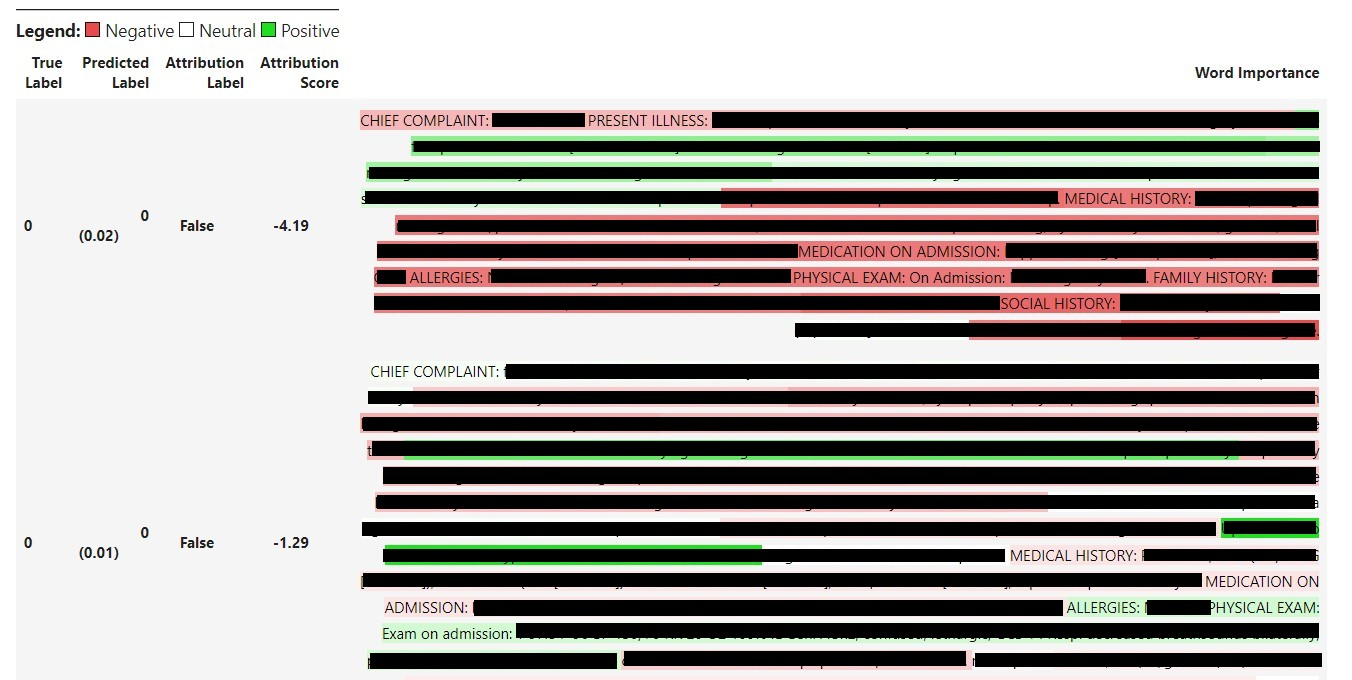

In [4]:
Image("img/sample-explainability-summary.jpg")

In [ ]:
_ = visualization.visualize_text(vis)

### Clean Up

Clean up the deployed models to not incur further charges

In [ ]:
predictor.delete_endpoint()